# Load Dataset


In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds 
import os
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Layer, Conv2D, MaxPooling2D, GlobalAveragePooling2D,BatchNormalization, Reshape, Conv2DTranspose, Dropout
import time

from IPython import display
from tqdm import tqdm

In [2]:
import urllib
categories = [line.rstrip(b'\n') for line in urllib.request.urlopen('https://raw.githubusercontent.com/googlecreativelab/quickdraw-dataset/master/categories.txt')]
print(categories[:10])
category = 'candle'

[b'aircraft carrier', b'airplane', b'alarm clock', b'ambulance', b'angel', b'animal migration', b'ant', b'anvil', b'apple', b'arm']


In [3]:
# Creates a folder to download the original drawings into.
# We chose to use the numpy format : 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

if not os.path.isdir('npy_files'):
    os.mkdir('npy_files')
    
url = f'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/{category}.npy'  
urllib.request.urlretrieve(url, f'npy_files/{category}.npy')

images = np.load(f'npy_files/{category}.npy')
print(f'{len(images)} images to train on')

# You can limit the amount of images you use for training by setting :
train_images = images[:10000]
# You should also define a samller subset of the images for testing..
# TODO
test_images = images[10000:12000]
print(len(test_images))
print(len(train_images))
# Notice that this to numpy format contains 1x784 pixel vectors, with values going from 0 (white) to 255 (black). We reshape them later to 28x28 grids and normalize the pixel intensity to [-1, 1]

141545 images to train on
2000
10000


In [4]:
# define shuffle and batching sizes
batch_size = 16
shuffle_size = 1000
prefetch_size = 32

In [5]:
def preprocess(data):
    # # change dtype to float32
    # data = data.map(lambda img, label: (tf.cast(img, tf.float32), label))
    # # change value range from 0-255 to -1 - 1
    # data = data.map(lambda img, label: ((img/128)-1, label))
    # # change format to 28,28,1
    # data = data.map(lambda img, label: (tf.reshape(img, (28,28,1)), label))

    data = data.map(lambda img: tf.cast(img, tf.float32))
    # change value range from 0-255 to -1 - 1
    data = data.map(lambda img: (img/128)-1)
    # change format to 28,28,1
    data = data.map(lambda img: tf.reshape(img, (28,28,1)))

    # do other prepocessing stuff
    data = data.shuffle(shuffle_size).batch(batch_size).prefetch(prefetch_size)
    return data




# Data Pipeline


In [6]:
# create datasets from tensor
labels = np.ones_like(train_images)
labels_test = np.ones_like(test_images)

# train_ds = tf.data.Dataset.from_tensor_slices((train_images,labels))
# test_ds = tf.data.Dataset.from_tensor_slices((test_images, labels_test))
train_ds = tf.data.Dataset.from_tensor_slices(train_images)
test_ds = tf.data.Dataset.from_tensor_slices(test_images)

train_ds = preprocess(train_ds)
test_ds = preprocess(test_ds)

#check data format real quick
# for x in test_ds:
#     print(x)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-01-16 17:49:10.871612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-16 17:49:10.872552: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Discriminator 

In [7]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.l = [
            Conv2D(32,kernel_size=2, padding='same'),
            Conv2D(32, kernel_size=3, padding='same'),
            Dropout(0.5),
            BatchNormalization(),
            Conv2D(32, kernel_size=2, padding='same'),
            Conv2D(32, kernel_size=2, padding='same'),
            Dropout(0.5),
            BatchNormalization(),
            Dense(1, activation='sigmoid')
        ]


    @tf.function
    def call(self, x, training):
        for l in self.l:
           x = l(x)
        return x 


# Generator Class


In [8]:
class Generator(Model):
    def __init__(self):
        super(Generator, self).__init__()
        self.l = [
            Dense(49, activation='relu'),
            Reshape((7,7,1)),
            Conv2DTranspose(32, kernel_size=(2,2), strides=2, activation="relu", padding='same'),
            BatchNormalization(),
            Conv2DTranspose(32, kernel_size=(2,2), strides=2, activation='relu', padding='same'),
            BatchNormalization(),
            Conv2DTranspose(32, kernel_size=(2,2), strides=2, activation='relu', padding='same'),
            BatchNormalization(),
            Conv2D(1, kernel_size=2, strides=2, activation='tanh', padding='same')
        ]


    def call(self, x, training):
        for l in self.l:
            x = l(x)
        return x

In [9]:
G_Test = Generator()
x = tf.random.normal([batch_size,49])
x = G_Test(x)
#print(x)

In [10]:
def train_step(G,D,G_optimizer, D_optimizer, data, noise):
    with tf.GradientTape() as G_tape, tf.GradientTape() as D_tape:

        fake_data = G(noise)
        fake_data_pred = D(fake_data)
        real_data_pred = D(data)

        D_loss = -tf.math.reduce_mean( tf.math.log(real_data_pred) + tf.math.log(1-fake_data_pred) )    
        G_loss = tf.math.reduce_mean( tf.math.log(1-fake_data_pred) )

        D_gradients = D_tape.gradient(D_loss, D.trainable_variables)
        D_optimizer.apply_gradients(zip(D_gradients, D.trainable_variables))

        G_gradients = G_tape.gradient(G_loss, G.trainable_variables)
        G_optimizer.apply_gradients(zip(G_gradients, G.trainable_variables))



In [11]:
# maybe seperate test function
def test(D, G, data, noise):

    test_loss_aggregator_d = []
    test_loss_aggregator_g = []
    
    for d in data:
        # process data and get predictions
        fake_data = G(noise)
        fake_data_pred = D(fake_data)
        real_data_pred = D(d)
        # compute loss for both networks
        D_loss = -tf.math.reduce_mean( tf.math.log(real_data_pred) + tf.math.log(1-fake_data_pred) )    
        G_loss = tf.math.reduce_mean( tf.math.log(1-fake_data_pred) )
        # append losses to array 
        test_loss_aggregator_d.append(D_loss)
        test_loss_aggregator_g.append(G_loss)
    #compute loss mean for 
    D_loss = tf.reduce_mean(test_loss_aggregator_d)
    G_loss = tf.reduce_mean(test_loss_aggregator_g)

    return D_loss, G_loss


Firing up Generator and Discriminator


  0%|          | 0/625 [00:00<?, ?it/s]2022-01-16 17:49:12.250022: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-16 17:49:12.251436: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-16 17:49:12.671025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-16 17:49:13.075784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-16 17:49:13.502919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-16 17:49:14.704003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-16 17:49:15.978742: I tensorflow/core/grappler/optimizer

Generator Loss for epoch: 0tf.Tensor(1.3844548, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 0tf.Tensor(-0.6600987, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.89it/s]


Generator Loss for epoch: 1tf.Tensor(1.369616, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 1tf.Tensor(-0.6304111, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.50it/s]


Generator Loss for epoch: 2tf.Tensor(1.4040283, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 2tf.Tensor(-0.6729865, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.81it/s]


Generator Loss for epoch: 3tf.Tensor(1.3849608, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 3tf.Tensor(-0.6697185, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.96it/s]


Generator Loss for epoch: 4tf.Tensor(1.3655561, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 4tf.Tensor(-0.6847601, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.73it/s]


Generator Loss for epoch: 5tf.Tensor(1.411388, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 5tf.Tensor(-0.66192067, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 29.97it/s]


Generator Loss for epoch: 6tf.Tensor(1.3815491, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 6tf.Tensor(-0.72106826, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.80it/s]


Generator Loss for epoch: 7tf.Tensor(1.3890806, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 7tf.Tensor(-0.6695204, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.61it/s]


Generator Loss for epoch: 8tf.Tensor(1.357306, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 8tf.Tensor(-0.783135, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.56it/s]


Generator Loss for epoch: 9tf.Tensor(1.3800381, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 9tf.Tensor(-0.6340491, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.65it/s]


Generator Loss for epoch: 10tf.Tensor(1.3034173, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 10tf.Tensor(-0.7796924, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.73it/s]


Generator Loss for epoch: 11tf.Tensor(1.3728721, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 11tf.Tensor(-0.6884635, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.76it/s]


Generator Loss for epoch: 12tf.Tensor(1.3817579, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 12tf.Tensor(-0.68596774, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.70it/s]


Generator Loss for epoch: 13tf.Tensor(1.3845886, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 13tf.Tensor(-0.69476014, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.44it/s]


Generator Loss for epoch: 14tf.Tensor(1.385149, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 14tf.Tensor(-0.69167346, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.53it/s]


Generator Loss for epoch: 15tf.Tensor(1.3852903, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 15tf.Tensor(-0.691291, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.56it/s]


Generator Loss for epoch: 16tf.Tensor(1.3853797, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 16tf.Tensor(-0.6899466, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.98it/s]


Generator Loss for epoch: 17tf.Tensor(1.386111, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 17tf.Tensor(-0.6989435, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.95it/s]


Generator Loss for epoch: 18tf.Tensor(1.3861647, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 18tf.Tensor(-0.6856137, shape=(), dtype=float32)


100%|██████████| 625/625 [00:20<00:00, 30.67it/s]


Generator Loss for epoch: 19tf.Tensor(1.3341656, shape=(), dtype=float32)
Discriminator Loss for this epoch is: 19tf.Tensor(-0.6731842, shape=(), dtype=float32)


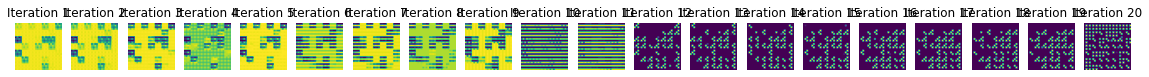

In [12]:
num_epochs = 20

test_losses = []
images_generated = []

fig = plt.figure(figsize=(20,10))
rows = 1
columns = num_epochs

G = Generator()
D = Discriminator()
D_optimizer = tf.keras.optimizers.Adam()
G_optimizer = tf.keras.optimizers.Adam()

test_noise = tf.random.normal([batch_size,100])
visualization_noise = tf.random.normal([1,100])


print("Firing up Generator and Discriminator")

for epoch in range(num_epochs):       
    losses_gen = []
    losses_dis = []     
    loss_epoch_gen = []
    loss_epoch_dis = []
    for data in tqdm(train_ds):
        z = tf.random.normal([batch_size,100])
        train_step(G,D,G_optimizer=G_optimizer, D_optimizer=D_optimizer, data=data, noise=z)


    test_loss_g, test_loss_d = test(D,G,test_ds, test_noise)
    test_losses.append([test_loss_g,test_loss_d])
    loss_epoch_gen.append(tf.reduce_mean(losses_gen))
    loss_epoch_dis.append(tf.reduce_mean(losses_dis))

    print("Generator Loss for epoch: "+ str(epoch) + str(test_loss_g))
    print("Discriminator Loss for this epoch is: " + str(epoch) + str(test_loss_d))


    generated = G(visualization_noise)
    generated = tf.reshape(generated, (28,28,1))
    images_generated.append(generated)

    fig.add_subplot(rows, columns, epoch+1)
    # showing image
    plt.imshow(generated)
    plt.axis('off')
    plt.title('Iteration '+ str(epoch+1))



        


TypeError: Invalid shape (784,) for image data

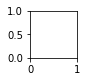

In [15]:
fig = plt.figure(figsize=(20,10))
rows = 1
columns = num_epochs


for i in range(num_epochs):
    fig.add_subplot(rows, columns, i+1)
    # showing image
    plt.imshow(images[i])
    plt.axis('off')
    plt.title('Iteration '+ str(i+1))

plt.imshow(images[0])

